<a href="https://colab.research.google.com/github/sailkargutkar/Python-Projects/blob/HELBNTODR100382/HELBNTODR100382.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [62]:
from __future__ import division, print_function
from gensim import models
from keras.callbacks import ModelCheckpoint
from keras.layers import Dense, Dropout, Reshape, Flatten, concatenate, Input, Conv1D, GlobalMaxPooling1D, Embedding
from keras.layers.recurrent import LSTM
from keras.models import Sequential
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import os
import collections
import requests
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize, WordNetLemmatizer
from keras.optimizers import Adam

nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
# The cell will produce the list of package versions loaded in the notebook. 
import pip

!pip freeze

absl-py==0.9.0
alabaster==0.7.12
albumentations==0.1.12
altair==4.1.0
asgiref==3.2.10
astor==0.8.1
astropy==4.0.1.post1
astunparse==1.6.3
atari-py==0.2.6
atomicwrites==1.4.0
attrs==19.3.0
audioread==2.1.8
autograd==1.3
Babel==2.8.0
backcall==0.2.0
beautifulsoup4==4.6.3
bleach==3.1.5
blis==0.4.1
bokeh==1.4.0
boto==2.49.0
boto3==1.14.22
botocore==1.17.22
Bottleneck==1.3.2
branca==0.4.1
bs4==0.0.1
CacheControl==0.12.6
cachetools==4.1.1
catalogue==1.0.0
certifi==2020.6.20
cffi==1.14.0
chainer==7.4.0
chardet==3.0.4
click==7.1.2
cloudpickle==1.3.0
cmake==3.12.0
cmdstanpy==0.4.0
colorlover==0.3.0
community==1.0.0b1
contextlib2==0.5.5
convertdate==2.2.1
coverage==3.7.1
coveralls==0.5
crcmod==1.7
cufflinks==0.17.3
cvxopt==1.2.5
cvxpy==1.0.31
cycler==0.10.0
cymem==2.0.3
Cython==0.29.21
daft==0.0.4
dask==2.12.0
dataclasses==0.7
datascience==0.10.6
decorator==4.4.2
defusedxml==0.6.0
descartes==1.1.0
dill==0.3.2
distributed==1.25.3
Django==3.0.8
dlib==19.18.0
docopt==0.6.2
docutils==0.15.2
dopamine

In [28]:
# Function to remove any punctuation in the text
def remove_punctuation(text):
    text_nopunct = ''
    text_nopunct = re.sub('['+string.punctuation+']', '', text)
    return text_nopunct

In [29]:
# We want to lowercase the dataset to eliminate any potential issues. There is a possibility that we lose context
def lowercase_token(tokens): 
    return [w.lower() for w in tokens]    

In [30]:
# Build a function to iterate through the dataset to remove any stop words
def remove_stop_words(tokens): 
    return [word for word in tokens if word not in stoplist]

In [47]:
# This function will get return the word embedding from the provided tokens 
def get_average_word2vec(tokens_list, vector, generate_missing=False, k=300):
    if len(tokens_list)<1:
        return np.zeros(k)
    if generate_missing:
        vectorized = [vector[word] if word in vector else np.random.rand(k) for word in tokens_list]
    else:
        vectorized = [vector[word] if word in vector else np.zeros(k) for word in tokens_list]
    length = len(vectorized)
    summed = np.sum(vectorized, axis=0)
    averaged = np.divide(summed, length)
    return averaged

In [31]:
# Lets import the provided datatset needed for the model evaluation
source_data = pd.read_csv('/content/agr_en_train.csv', header = None, delimiter=',')

In [32]:
# Here we add some color to the imported dataset
source_data.columns = ['unique_id','text','aggression']

In [33]:
label_l_data = []
OAG = []
CAG = []
NAG = []

for label_data in source_data.aggression:
    if label_data == 'OAG':
        label_l_data.append(3)
        OAG.append(1)
        CAG.append(0)
        NAG.append(0)
    elif label_data == 'CAG':
        label_l_data.append(2)
        OAG.append(0)
        CAG.append(1)
        NAG.append(0)
    elif label_data == 'NAG':
        label_l_data.append(1)
        OAG.append(0)
        CAG.append(0)
        NAG.append(1)

source_data['agression_level_classification']= label_l_data
source_data['OAG']= OAG
source_data['CAG']= CAG
source_data['NAG']= NAG

In [34]:
source_data['Text_Clean'] = source_data['text'].apply(lambda x: remove_punctuation(x))

In [35]:
tokens = [word_tokenize(sen) for sen in source_data.Text_Clean] 

In [36]:
# Make the dataset all lowercase   
lower_tokens = [lowercase_token(token) for token in tokens] 

In [37]:
stoplist = stopwords.words('english')

In [38]:
# Up until the step, the text has undergone the following transformations
filtered_words = [remove_stop_words(sen) for sen in lower_tokens] 

In [39]:
# Now we create a clean dataset without punctuation and stopwords
result = [' '.join(sen) for sen in filtered_words] 

In [40]:
# Append the source_data dataframe with the cleansed text 
source_data['Text_Final'] = result

In [41]:
# Append the source_data dataframe with the clean tokenized data 
source_data['tokens'] = filtered_words

In [42]:
# Build a new data frame with the clean text and transposed data 
input_source_data = source_data[['Text_Final', 'CAG', 'NAG', 'OAG', 'tokens', 'aggression', 'agression_level_classification']]

In [43]:
# Split data into test and train
# We need to create training, and testing datasets, we will use the train_test_split function from Keras to achive this
source_data_train, source_data_test = train_test_split(input_source_data, test_size=0.10, random_state=42)

# Build a list 
all_training_words = [word for tokens in source_data_train["tokens"] for word in tokens]
training_sentence_lengths = [len(tokens) for tokens in source_data_train["tokens"]]

# Build a list vocabulary
training_vocabulary = sorted(list(set(all_training_words)))

In [44]:
all_test_words = [word for tokens in source_data_test["tokens"] for word in tokens]
test_sentence_lengths = [len(tokens) for tokens in source_data_test["tokens"]]
testing_vocabulary = sorted(list(set(all_test_words)))

In [45]:
# load the Google News Word2Vec model. 
word2vec_path = 'GoogleNews-vectors-negative300.bin.gz'

def download_word2vec_model(word2vec_path):
    if not os.path.isfile(word2vec_path):
        url = "https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz"
        word2vec_google_dataset = requests.get(url)
        open('GoogleNews-vectors-negative300.bin.gz', 'wb').write(word2vec_google_dataset.content)
        
download_word2vec_model(word2vec_path)

word2vec = models.KeyedVectors.load_word2vec_format(word2vec_path, binary=True)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:254: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [48]:
def get_word2vec_embeddings(vectors, clean_comments, generate_missing=False):
    embeddings = clean_comments['tokens'].apply(lambda x: get_average_word2vec(x, vectors, 
                                                                                generate_missing=generate_missing))
    return list(embeddings)

In [50]:
training_embeddings = get_word2vec_embeddings(word2vec, source_data_train, generate_missing=True)

# Define some constant values which will affect the performance of the models 
MAX_SEQUENCE_LENGTH = 50
EMBEDDING_DIM = 300 

In [51]:
# This code block will vectorize the text corpus of cleansed data 
tokenizer = Tokenizer(num_words=len(training_vocabulary), lower=True, char_level=False)
tokenizer.fit_on_texts(source_data_train["Text_Final"].tolist())
# This step will build a list containing the vectorized values in a sequence
training_sequences = tokenizer.texts_to_sequences(source_data_train["Text_Final"].tolist())
train_word_index = tokenizer.word_index

# This code block will pad and make sure that the input shape is consistant
train_cnn_data = pad_sequences(training_sequences, maxlen=MAX_SEQUENCE_LENGTH)

# This code block will get the embeddings from the pre-trained word and phrase vectors from Google News Word2Vec model
train_embedding_weights = np.zeros((len(train_word_index)+1, EMBEDDING_DIM))
for word,index in train_word_index.items():
    train_embedding_weights[index,:] = word2vec[word] if word in word2vec else np.random.rand(EMBEDDING_DIM)

test_sequences = tokenizer.texts_to_sequences(source_data_test["Text_Final"].tolist())
test_cnn_data = pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH)



In [71]:
# This function defines the CNN, including the paramters which can be passed to the model 
def ConvNet(embeddings, max_sequence_length, num_words, embedding_dim, labels_index):
    
    embedding_layer = Embedding(num_words,
                            embedding_dim,
                            weights=[embeddings],
                            input_length=max_sequence_length,
                            trainable=False)
    
    sequence_input = Input(shape=(max_sequence_length,), dtype='int32')
    embedded_sequences = embedding_layer(sequence_input)

    convs = []
    filter_sizes = [2,3,4,5,6]

    for filter_size in filter_sizes:
        l_conv = Conv1D(filters=300, kernel_size=filter_size, activation='relu')(embedded_sequences)
        l_pool = GlobalMaxPooling1D()(l_conv)
        convs.append(l_pool)

    l_merge = concatenate(convs, axis=1)

    x = Dropout(0.1)(l_merge)  
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.2)(x)
    preds = Dense(labels_index, activation='sigmoid')(x)

    model = Model(sequence_input, preds)
    model.compile(loss='binary_crossentropy',
                  optimizer=Adam(learning_rate=0.01),
                  metrics=['acc'])
    model.summary()
    return model

In [72]:
label_names = ['OAG', 'CAG', 'NAG'] 
# Append our aggression lables to our test and train datasets 
y_train = source_data_train[label_names].values
y_test = source_data_test[label_names].values

x_train = train_cnn_data
y_tr = y_train
x_test = test_cnn_data
y_tst = y_test

In [73]:
# Execute the model and get a summary of the model
model = ConvNet(train_embedding_weights, MAX_SEQUENCE_LENGTH, len(train_word_index)+1, EMBEDDING_DIM, 
                len(list(label_names)))

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 50)           0                                            
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, 50, 300)      7268400     input_4[0][0]                    
__________________________________________________________________________________________________
conv1d_16 (Conv1D)              (None, 49, 300)      180300      embedding_4[0][0]                
__________________________________________________________________________________________________
conv1d_17 (Conv1D)              (None, 48, 300)      270300      embedding_4[0][0]                
____________________________________________________________________________________________

In [74]:
# Train our CNN model with the below parameters
num_epochs = 1
batch_size = 100

hist = model.fit(x_train, y_tr, epochs=num_epochs, validation_split=0.1, shuffle=True, batch_size=batch_size)

#predictions = model.predict(test_cnn_data, batch_size=1024, verbose=1)
predictions = model.fit(x_test, y_tst, epochs=num_epochs, validation_split=0.1, shuffle=True, batch_size=batch_size)

loss, accuracy = model.evaluate(x_train, y_tr, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(x_test, y_tst, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Train on 9719 samples, validate on 1080 samples
Epoch 1/1
9719/9719 [==============================] - 69s 7ms/step - loss: 0.7651 - acc: 0.6780 - val_loss: 0.5561 - val_acc: 0.7139
Train on 1080 samples, validate on 120 samples
Epoch 1/1
1080/1080 [==============================] - 8s 7ms/step - loss: 0.5531 - acc: 0.7151 - val_loss: 0.5562 - val_acc: 0.7028
Training Accuracy: 0.7245
Testing Accuracy:  0.7272


In [ ]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(training):
    acc = training.history['acc']
    val_acc = training.history['val_acc']
    loss = training.history['loss']
    val_loss = training.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(14, 8))
    plt.subplot(1, 2, 2)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

In [75]:
from sklearn.metrics import f1_score, precision_score

predictions = model.predict(test_cnn_data, batch_size=1024, verbose=1)

predictions_x = np.argmax(y_tst, axis=1)
predictions_y = np.argmax(predictions, axis=1)
f1_score(predictions_x,predictions_y,average="micro")

1200/1200 [==============================] - 3s 3ms/step


0.585

In [76]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(predictions_x,predictions_y))

[[ 46 166  31]
 [ 12 272 160]
 [  6 123 384]]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


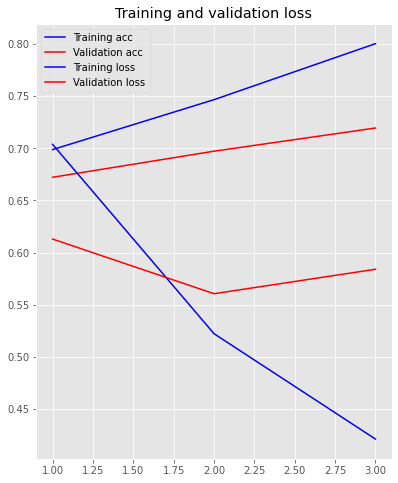

In [ ]:
plot_history(predictions)